# 🎬 IMDB Sentiment Analysis using RNN (Recurrent Neural Network)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,SimpleRNN,Dense

Loading the IMDB Dataset

In [3]:
# load data
vocab_size = 10000
(X_train,y_train),(X_test,y_test) = imdb.load_data(num_words= vocab_size)

print(f"Training data:{X_train.shape}, training labels: {y_train.shape}")
print(f"Training data:{X_test.shape}, training labels: {y_test.shape}")

Training data:(25000,), training labels: (25000,)
Training data:(25000,), training labels: (25000,)


## Exploratory Data Analysis (EDA)

Class distribution in training set: {np.int64(0): np.int64(12500), np.int64(1): np.int64(12500)}


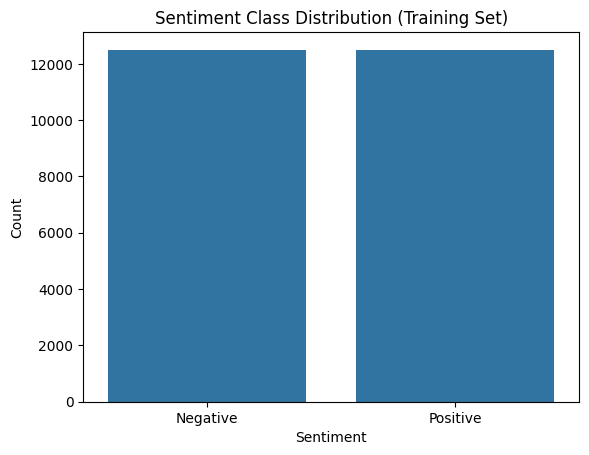

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class balance
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Class distribution in training set:", class_counts)

# Plot
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.title('Sentiment Class Distribution (Training Set)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

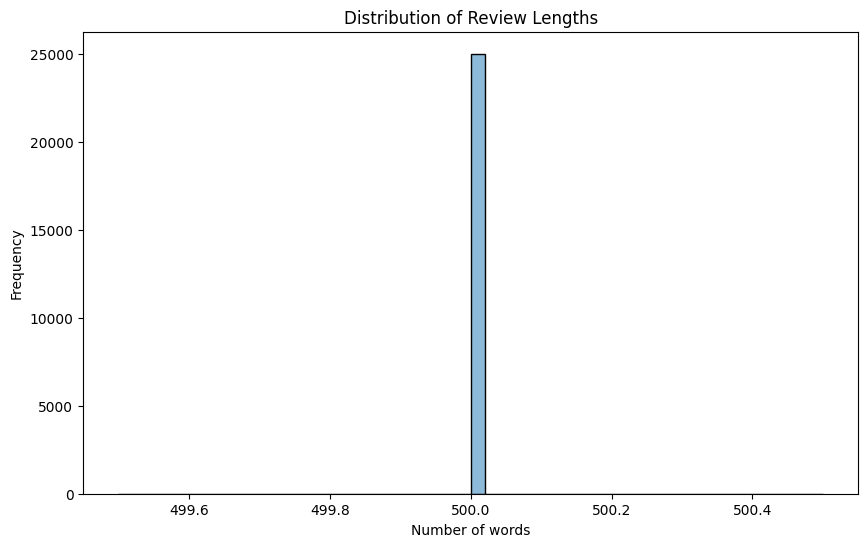

Average review length: 500.00
Max review length: 500
Min review length: 500


In [14]:
review_lengths = [len(review) for review in X_train]

plt.figure(figsize=(10, 6))
sns.histplot(review_lengths, bins=50, kde=True)
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

print(f"Average review length: {np.mean(review_lengths):.2f}")
print(f"Max review length: {np.max(review_lengths)}")
print(f"Min review length: {np.min(review_lengths)}")

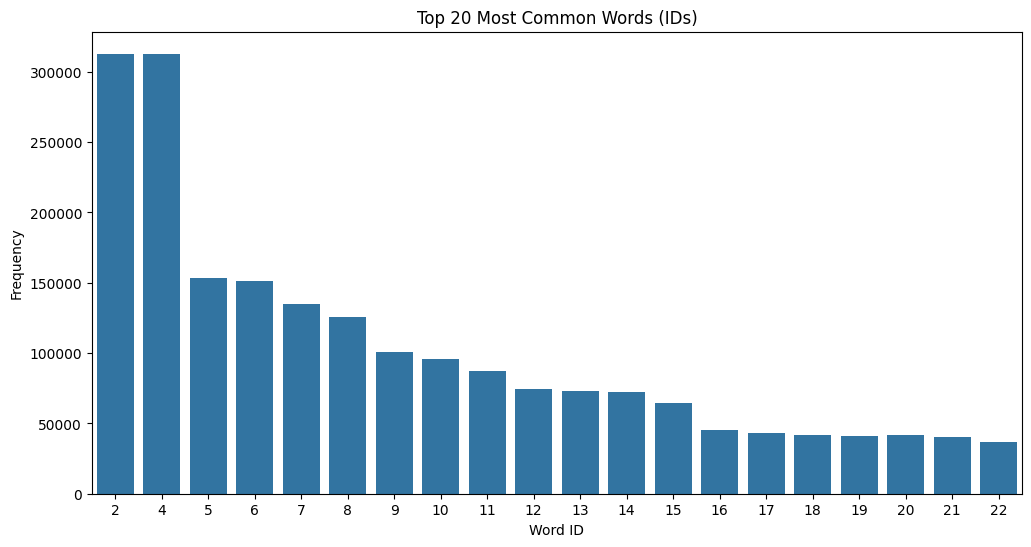

In [15]:
from collections import Counter

# Flatten all training reviews into one list
all_words = [word for review in X_train for word in review]
word_freq = Counter(all_words)

# Top 20 most common words (ignore 0 padding)
most_common = word_freq.most_common(21)[1:]  # skip 0

words, freqs = zip(*most_common)
plt.figure(figsize=(12, 6))
sns.barplot(x=list(words), y=list(freqs))
plt.title("Top 20 Most Common Words (IDs)")
plt.xlabel("Word ID")
plt.ylabel("Frequency")
plt.show()

## 🔍 Decoding an Example Review

In [4]:
# Load word index mapping
word_index = imdb.get_word_index()

# Reverse word index
reverse_word_index = {value: key for key, value in word_index.items()}

# Decode first review
decoded_review = " ".join([reverse_word_index.get(i - 3, "?") for i in X_train[0]])
print(decoded_review)

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should

In [5]:
max_length = 500

X_train = sequence.pad_sequences(X_train,maxlen=max_length)
X_test = sequence.pad_sequences(X_test,maxlen=max_length)
X_train

array([[   0,    0,    0, ...,   19,  178,   32],
       [   0,    0,    0, ...,   16,  145,   95],
       [   0,    0,    0, ...,    7,  129,  113],
       ...,
       [   0,    0,    0, ...,    4, 3586,    2],
       [   0,    0,    0, ...,   12,    9,   23],
       [   0,    0,    0, ...,  204,  131,    9]], dtype=int32)

In [6]:
model = Sequential()
model.add(Embedding(vocab_size,128,input_length=max_length)) #embedding layer
model.add(SimpleRNN(128,activation= 'relu'))
model.add(Dense(1,activation='sigmoid'))

model.build((None, max_length))  # 👈 Explicitly build the model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [7]:
model.compile(optimizer='adam',loss= 'binary_crossentropy',metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 500, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,313,025 (5.01 MB)

 Trainable params: 1,313,025 (5.01 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss',patience =5, restore_best_weights = True)
early_stopping

## 🏗️ Building the RNN Model


In [10]:
history = model.fit(
    X_train,y_train,epochs = 10,batch_size = 32,
    validation_split = 0.2,
    callbacks = [early_stopping]
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 149s 235ms/step - accuracy: 0.6010 - loss: 0.7458 - val_accuracy: 0.6470 - val_loss: 0.6023
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 143s 229ms/step - accuracy: 0.7359 - loss: 0.5335 - val_accuracy: 0.6686 - val_loss: 0.5852
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 145s 232ms/step - accuracy: 0.8045 - loss: 0.4300 - val_accuracy: 0.7622 - val_loss: 0.5384
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 202s 232ms/step - accuracy: 0.8841 - loss: 0.2781 - val_accuracy: 0.8314 - val_loss: 0.4164
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 213s 249ms/step - accuracy: 0.9379 - loss: 0.1684 - val_accuracy: 0.8262 - val_loss: 0.4671
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 195s 238ms/step - accuracy: 0.9486 - loss: 0.1387 - val_accuracy: 0.7646 - val_loss: 0.5583
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 195s 226ms/step - accuracy: 0.9485 - loss: 0.1437 - val_accuracy: 0.8310 - val_loss: 0.5840
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 145s 230ms/step - accuracy: 0.9676 -

In [12]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.8292 - loss: 0.4178
Test Accuracy: 0.8338, Test Loss: 0.4080


In [16]:
model.save('simple_rnn_imdb.keras')

In [17]:
from google.colab import files
files.download("simple_rnn_imdb.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>